In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import six
import tensorflow_datasets as tfds

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [2]:
celeba = tfds.load('celeb_a')

Dl Completed...: 0 url [00:00, ? url/s]
Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]
Generating train examples...: 0 examples [00:00, ? examples/s]
Generating train examples...: 1 examples [00:03,  3.11s/ examples]
Generating train examples...: 96 examples [00:03, 42.03 examples/s]
Generating train examples...: 196 examples [00:03, 98.54 examples/s]
Generating train examples...: 290 examples [00:03, 163.84 examples/s]
Generating train examples...: 385 examples [00:03, 242.32 examples/s]
Generating train examples...: 478 examples [00:03, 327.85 examples/s]
Generating train examples...: 575 examples [00:03, 424.85 examples/s]
Generating train examples...: 681 examples [00:03, 537.64 examples/s]
Generating train examples...: 787 examples [00:03, 642.75 examples/s]
Generating train examples...: 886 examples [00:04, 718.45 examples/s]
Generating train examples...: 985 examples [00:04, 780.00 examples/s]
Generating train examples...: 1090 examples [00:04, 847.44 examples/

Dataset celeb_a downloaded and prepared to ~/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


In [3]:
CLASSES = [
    '5_o_Clock_Shadow',
    'Arched_Eyebrows',
    'Attractive',
    'Bags_Under_Eyes',
    'Bald',
    'Bangs',
    'Big_Lips',
    'Big_Nose',
    'Black_Hair',
    'Blond_Hair',
    'Blurry',
    'Brown_Hair',
    'Bushy_Eyebrows',
    'Chubby',
    'Double_Chin',
    'Eyeglasses',
    'Goatee',
    'Gray_Hair',
    'Heavy_Makeup',
    'High_Cheekbones',
    'Male',
    'Mouth_Slightly_Open',
    'Mustache',
    'Narrow_Eyes',
    'No_Beard',
    'Oval_Face',
    'Pale_Skin',
    'Pointy_Nose',
    'Receding_Hairline',
    'Rosy_Cheeks',
    'Sideburns',
    'Smiling',
    'Straight_Hair',
    'Wavy_Hair',
    'Wearing_Earrings',
    'Wearing_Hat',
    'Wearing_Lipstick',
    'Wearing_Necklace',
    'Wearing_Necktie',
    'Young']

In [4]:
def preprocess(e):
    res = e['image']
    res = tf.image.resize_with_pad(res, 128, 128)
    res = tf.cast(res, tf.float32) / 255. - 0.5
    
    labels = []
    for c in CLASSES:
        labels.append(tf.cast(e['attributes'][c], tf.float32))
    labels = tf.stack(labels)
    return res, labels

ds_train = celeba['train'].map(preprocess).shuffle(10000).batch(64, drop_remainder=True)
ds_test = celeba['validation'].map(preprocess).batch(64, drop_remainder=True)

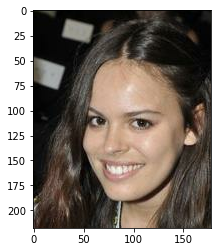

In [5]:
for e in celeba['train'].take(1):
    pass
plt.imshow(e['image'].numpy())

# Training

In [6]:
class CelebaModel(tf.keras.Model):
    def __init__(self, num_layers=5, channels=128, channel_mult=[]):
        super().__init__()
        
        self.num_layers = num_layers
        self.channels = channels
        
        self.initial_block = tf.keras.models.Sequential()
        self.initial_block.add(tf.keras.layers.Conv2D(channels, (3, 3)))
        self.initial_block.add(tf.keras.layers.Activation('relu'))
        self.initial_block.add(tf.keras.layers.LayerNormalization())
        
        self.blocks = tf.keras.models.Sequential()
        for l in range(num_layers):
            mult = 1
            if channel_mult:
                mult = channel_mult[min(l, len(channel_mult) - 1)]
            block = tf.keras.models.Sequential()
            block.add(tf.keras.layers.Conv2D(channels * mult, (3, 3)))
            block.add(tf.keras.layers.Activation('relu'))
            block.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
            block.add(tf.keras.layers.LayerNormalization())
            block.add(tf.keras.layers.Dropout(0.2))
            self.blocks.add(block)
            
        self.outer = tf.keras.layers.GlobalAveragePooling2D()
        self.dnn = tf.keras.models.Sequential()
        self.dnn.add(tf.keras.layers.Dense(64))
        self.dnn.add(tf.keras.layers.Activation('relu'))
        self.dnn.add(tf.keras.layers.Dense(len(CLASSES)))
        
        
    def call(self, inputs, training=False):
        flow = inputs
        flow = self.initial_block(flow)
        flow = self.blocks(flow, training=training)
        flow = self.outer(flow)
        flow = self.dnn(flow, training=training)
        return flow

In [7]:
model = CelebaModel(num_layers=5, channels=64, channel_mult=[1, 1, 2, 2, 2])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(3e-4))

In [ ]:
model.fit(ds_train, epochs=10, validation_data=ds_test)

# Evaluation

In [14]:
labels = []
preds = []
for e, l in ds_test:
    labels.extend(l.numpy())
    preds.extend(model.predict(e, verbose=False))
labels = np.array(labels)
preds = np.array(preds)

In [15]:
from sklearn.metrics import roc_auc_score

for i, c in enumerate(CLASSES):
    print('AUC for %s: %.3f' % (c, roc_auc_score(labels[:, i], preds[:, i])))

AUC for 5_o_Clock_Shadow: 0.970
AUC for Arched_Eyebrows: 0.920
AUC for Attractive: 0.908
AUC for Bags_Under_Eyes: 0.882
AUC for Bald: 0.994
AUC for Bangs: 0.988
AUC for Big_Lips: 0.795
AUC for Big_Nose: 0.883
AUC for Black_Hair: 0.961
AUC for Blond_Hair: 0.984
AUC for Blurry: 0.964
AUC for Brown_Hair: 0.910
AUC for Bushy_Eyebrows: 0.950
AUC for Chubby: 0.956
AUC for Double_Chin: 0.965
AUC for Eyeglasses: 0.999
AUC for Goatee: 0.986
AUC for Gray_Hair: 0.987
AUC for Heavy_Makeup: 0.981
AUC for High_Cheekbones: 0.954
AUC for Male: 0.999
AUC for Mouth_Slightly_Open: 0.985
AUC for Mustache: 0.977
AUC for Narrow_Eyes: 0.938
AUC for No_Beard: 0.989
AUC for Oval_Face: 0.736
AUC for Pale_Skin: 0.959
AUC for Pointy_Nose: 0.801
AUC for Receding_Hairline: 0.952
AUC for Rosy_Cheeks: 0.959
AUC for Sideburns: 0.988
AUC for Smiling: 0.984
AUC for Straight_Hair: 0.862
AUC for Wavy_Hair: 0.915
AUC for Wearing_Earrings: 0.947
AUC for Wearing_Hat: 0.995
AUC for Wearing_Lipstick: 0.985
AUC for Wearing_Neck